Permalink: https://colab.research.google.com/drive/1lxlKSjtHR-2kj0NWz7sWi46Ms9Q_guH9?usp=sharing

In [60]:
import pandas as pd
import numpy as np
dataset = pd.read_csv('https://s3.amazonaws.com/datarobot_public_datasets/DR_Demo_Fire_Ins_Loss_only.csv')
dataset.head(3)

,loss,Exposure,Rating_Class,Sub_Rating_Class,Renewal_class,Sub_Renewal_Class,Property_size,Residents,Commercial,Norm_fire_risk,Norm_monthly_rent,Loan_mortgage,No_claim_Years,Previous_claims,Norm_area_m,Premium_remain,Premium_renew,Renewal_Type,crime_property_type,crime_residents,crime_area,crime_arson,crime_burglary,crime_neighbour_watch,crime_community,crime_risk,Geographical_risk,Weather_risk,ISO,ISO_cat,ISO_desc
0,0.07,3.0,H1,NaN,NaN,NaN,3.0,4.0,NaN,4.314082,758.287544,2.673639,2.251423,0.0,10.0,NaN,0.000000,B,1.209807,1.064398,1.066522,0.939346,1.708534,0.808015,1.040819,1.171366,0.284447,0.313157,5,ISO 5 - Modified or Semi Fire Resistive (MFR o...,which and floors. greater roof _—– modified an...
1,0.13,NaN,M1,NaN,NaN,NaN,6.0,1.0,NaN,4.171214,1060.660172,2.709158,2.084180,NaN,NaN,NaN,86.666667,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006305,0.889677,6,ISO 6 - Fire Resistive (FR),bearing are walls deck/cover precast and/or co...
2,0.02,NaN,M1,NaN,NaN,NaN,4.0,1.0,NaN,4.171214,1060.660172,2.709158,2.084180,NaN,8.0,NaN,86.666667,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019372,0.276507,1,ISO 1 Frame (combustible walls or roof),*BUR 1B and covers the *Single-ply wood/hardip...


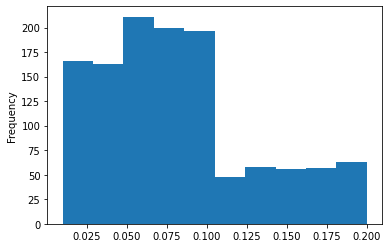

In [14]:
y.plot.hist(50)

In [68]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ElasticNet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

class StackingTransformer(BaseEstimator, TransformerMixin):
    """A transformer that wraps a RegressorMixin `est` predict function.
    
    It overloads `fit_transform` to do a stacked transform to avoid leakage.
    """
    def __init__(self, est):
        self.est = est
        
    def fit(self, X, y=None):
        if y is None:
            raise ValueError('{}.fit requires y to be not None'.format(self))
        self.est.fit(X, y)
        return self
    
    def transform(self, X):
        return self.est.predict(X)[:, np.newaxis]
    
    def fit_transform(self, X, y=None):
        if y is None:
            raise ValueError('{}.fit requires y to be not None'.format(self))
        self.models_ = []
        out = np.empty_like(y)[:, np.newaxis]
        for train, test in KFold(5, shuffle=True, random_state=0).split(X):
            self.models_.append(clone(self.est).fit(X[train], y[train]))
            out[test, 0] = self.models_[-1].predict(X[test])
        self.est = self.models_[0]
        return out

dataset = pd.read_csv('https://s3.amazonaws.com/datarobot_public_datasets/DR_Demo_Fire_Ins_Loss_only.csv')
dataset.head(3)


target_feature = 'loss'
categorical_features = ['Renewal_Type', 'Commercial','Renewal_class', 'ISO_cat', 'Rating_Class', 'Sub_Renewal_Class', 'Sub_Rating_Class']
numeric_features = ['crime_burglary',  'crime_risk', 'Norm_fire_risk', 'crime_arson', 'ISO', 'Weather_risk',  'Geographical_risk',  
                    'Premium_remain', 'crime_property_type', 'crime_neighbour_watch', 'Previous_claims', 'Exposure', 'crime_area', 
                    'Norm_monthly_rent',  'No_claim_Years', 'crime_residents', 'Norm_area_m', 'Property_size', 'Residents', 'crime_community', 
                    'Loan_mortgage', 'Premium_renew']
text_features = ['ISO_desc']

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-99999)),
    ])
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('fx_selection', SelectFromModel(ElasticNet(alpha=0.1), max_features=50, threshold=None))
])

text_pipeline = Pipeline(steps=[
    ('bow', CountVectorizer()),
    ('bow_reg', StackingTransformer(ElasticNet(alpha=0.1)))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features),
        ('text', text_pipeline, text_features[0])
    ])

est = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rf', RandomForestRegressor())])



y = dataset.pop(target_feature)
X = dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

# y should be an ndarray
y_train = y_train.values
y_test = y_test.values

grid = {'rf__n_estimators': np.linspace(start = 200, stop = 2000, num = 10).astype(int),
               'rf__max_features': np.linspace(2, 10, num = 5).astype(int),
               'rf__max_depth':np.linspace(2, 32, num = 8).astype(int)}
rs = RandomizedSearchCV(est, param_distributions=grid, scoring='neg_mean_squared_error', n_iter=400)
rs.fit(X_train, y_train);
#print(f"rs.best_params_: {rs.best_params_}")   
print("best params: {}".format(rs.best_params_))
print("model score: %.3f" % mean_absolute_error(y_test, rs.best_estimator_.predict(X_test)))           

best params: {'rf__n_estimators': 1000, 'rf__max_features': 10, 'rf__max_depth': 23}
model score: 0.036


In [75]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ElasticNet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Integer

class StackingTransformer(BaseEstimator, TransformerMixin):
    """A transformer that wraps a RegressorMixin `est` predict function.
    
    It overloads `fit_transform` to do a stacked transform to avoid leakage.
    """
    def __init__(self, est):
        self.est = est
        
    def fit(self, X, y=None):
        if y is None:
            raise ValueError('{}.fit requires y to be not None'.format(self))
        self.est.fit(X, y)
        return self
    
    def transform(self, X):
        return self.est.predict(X)[:, np.newaxis]
    
    def fit_transform(self, X, y=None):
        if y is None:
            raise ValueError('{}.fit requires y to be not None'.format(self))
        self.models_ = []
        out = np.empty_like(y)[:, np.newaxis]
        for train, test in KFold(5, shuffle=True, random_state=0).split(X):
            self.models_.append(clone(self.est).fit(X[train], y[train]))
            out[test, 0] = self.models_[-1].predict(X[test])
        self.est = self.models_[0]
        return out

dataset = pd.read_csv('https://s3.amazonaws.com/datarobot_public_datasets/DR_Demo_Fire_Ins_Loss_only.csv')
dataset.head(3)


target_feature = 'loss'
categorical_features = ['Renewal_Type', 'Commercial','Renewal_class', 'ISO_cat', 'Rating_Class', 'Sub_Renewal_Class', 'Sub_Rating_Class']
numeric_features = ['crime_burglary',  'crime_risk', 'Norm_fire_risk', 'crime_arson', 'ISO', 'Weather_risk',  'Geographical_risk',  
                    'Premium_remain', 'crime_property_type', 'crime_neighbour_watch', 'Previous_claims', 'Exposure', 'crime_area', 
                    'Norm_monthly_rent',  'No_claim_Years', 'crime_residents', 'Norm_area_m', 'Property_size', 'Residents', 'crime_community', 
                    'Loan_mortgage', 'Premium_renew']
text_features = ['ISO_desc']

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-99999)),
    ])
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('fx_selection', SelectFromModel(ElasticNet(alpha=0.1), max_features=50, threshold=None))
])

text_pipeline = Pipeline(steps=[
    ('bow', CountVectorizer()),
    ('bow_reg', StackingTransformer(ElasticNet(alpha=0.1)))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features),
        ('text', text_pipeline, text_features[0])
    ])

est = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rf', RandomForestRegressor())])


y = dataset.pop(target_feature)
X = dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

# y should be an ndarray
y_train = y_train.values
y_test = y_test.values


search_space = {'rf__n_estimators': Integer( 200, 2000, prior='uniform'),
               'rf__max_features': Integer(2, 10, prior='uniform'),
               'rf__max_depth': Integer(2, 32, prior='uniform')}


opt = BayesSearchCV(
    est,
    search_space,
    optimizer_kwargs={'base_estimator': 'RF'},
    n_iter=100,
    cv=5,
    random_state=0
)

opt.fit(X_train, y_train)

print("best params: {}".format(opt.best_params_))
print("model score: %.3f" % mean_absolute_error(y_test, opt.best_estimator_.predict(X_test))) 

best params: OrderedDict([('rf__max_depth', 13), ('rf__max_features', 10), ('rf__n_estimators', 1601)])
model score: 0.036
